Retornos esperados anuales:
Bonos          0.03
Acciones EU    0.08
Acciones EM    0.10
Oro            0.04
Divisas        0.02
Name: Retorno esperado, dtype: float64

Matriz de covarianza anual:
              Bonos  Acciones EU  Acciones EM     Oro  Divisas
Bonos        0.0050      -0.0515       0.0205  0.0139  -0.0056
Acciones EU -0.0515       0.0400      -0.0175 -0.0544   0.0052
Acciones EM  0.0205      -0.0175       0.0600  0.0227  -0.0200
Oro          0.0139      -0.0544       0.0227  0.0200   0.0145
Divisas     -0.0056       0.0052      -0.0200  0.0145   0.0300

--- CARTERA DE MÍNIMA VARIANZA ---
Bonos: 19.8%
Acciones EU: 21.0%
Acciones EM: 19.7%
Oro: 19.7%
Divisas: 19.7%
Rendimiento esperado: 5.43%
Volatilidad: 0.02%


/var/folders/2x/_hywqhn13dj1ph71r6gjfy_h0000gn/T/ipykernel_17833/4205309649.py:46: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(pesos.T, np.dot(cov, pesos)))


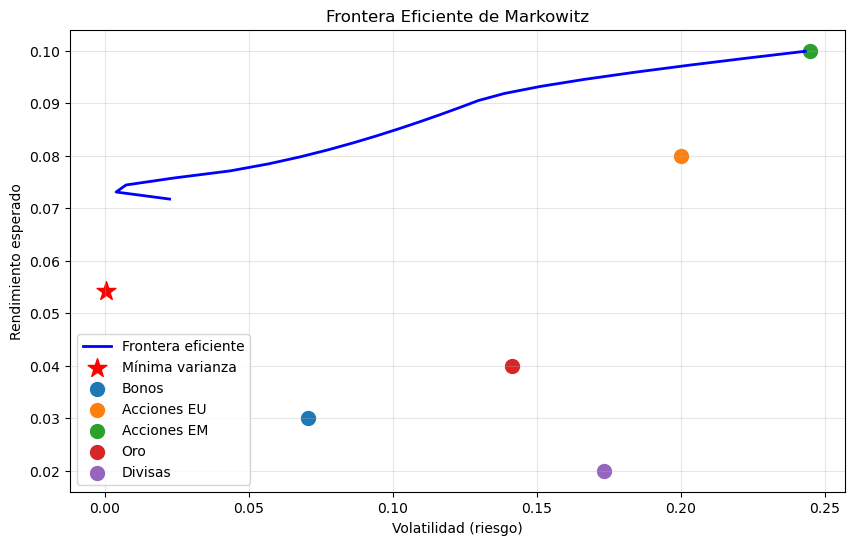


--- INTERPRETACIÓN PARA EL NEGOCIO ---
La frontera eficiente muestra las carteras óptimas que maximizan el rendimiento para cada nivel de riesgo.
Un gestor de carteras puede seleccionar un punto según el perfil de riesgo del cliente.
Los bancos utilizan esta teoría para construir carteras recomendadas (asset allocation).
Restricciones adicionales (pesos máximos, exclusión de ciertos activos) se pueden incorporar fácilmente.


In [1]:
# ============================================
# OPTIMIZACIÓN DE CARTERAS (FRONTERA EFICIENTE)
# Teoría Moderna de Portafolios - Harry Markowitz
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --------------------------------------------
# 1. Datos: rendimientos esperados y matriz de covarianza
# --------------------------------------------
# Activos: "Bonos", "Acciones EU", "Acciones EM", "Oro", "Divisas"
activos = ['Bonos', 'Acciones EU', 'Acciones EM', 'Oro', 'Divisas']
n_activos = len(activos)

# Rendimientos esperados anuales (%)
mu = np.array([0.03, 0.08, 0.10, 0.04, 0.02])

# Matriz de covarianza anual (simulada)
np.random.seed(123)
# Generar una matriz de covarianza semi-aleatoria pero definida positiva
A = np.random.randn(n_activos, n_activos)
cov = A @ A.T  # producto para que sea definida positiva
# Escalar para que las varianzas sean coherentes (diagonal aprox 0.05^2 a 0.2^2)
cov = cov / np.max(np.diag(cov)) * 0.1
np.fill_diagonal(cov, np.array([0.005, 0.04, 0.06, 0.02, 0.03]))  # varianzas

# Convertir a DataFrame para legibilidad
df_mu = pd.Series(mu, index=activos, name='Retorno esperado')
df_cov = pd.DataFrame(cov, index=activos, columns=activos)

print("Retornos esperados anuales:")
print(df_mu.round(4))
print("\nMatriz de covarianza anual:")
print(df_cov.round(4))

# --------------------------------------------
# 2. Funciones para calcular rendimiento y volatilidad de una cartera
# --------------------------------------------
def rendimiento_cartera(pesos):
    return np.dot(pesos, mu)

def volatilidad_cartera(pesos):
    return np.sqrt(np.dot(pesos.T, np.dot(cov, pesos)))

# --------------------------------------------
# 3. Optimización: encontrar la cartera de mínima varianza
# --------------------------------------------
# Restricción: suma de pesos = 1
restricciones = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Límites: cada peso entre 0 y 1 (no cortos)
limites = tuple((0, 1) for _ in range(n_activos))

# Punto inicial (equiponderado)
pesos_iniciales = n_activos * [1. / n_activos]

# Minimizar varianza
opt_min_var = minimize(volatilidad_cartera,
                       pesos_iniciales,
                       method='SLSQP',
                       bounds=limites,
                       constraints=restricciones)

pesos_min_var = opt_min_var.x
rend_min_var = rendimiento_cartera(pesos_min_var)
vol_min_var = volatilidad_cartera(pesos_min_var)

print("\n--- CARTERA DE MÍNIMA VARIANZA ---")
for i, activo in enumerate(activos):
    print(f"{activo}: {pesos_min_var[i]*100:.1f}%")
print(f"Rendimiento esperado: {rend_min_var*100:.2f}%")
print(f"Volatilidad: {vol_min_var*100:.2f}%")

# --------------------------------------------
# 4. Frontera eficiente: barrer rendimientos objetivo y minimizar varianza
# --------------------------------------------
rend_objetivo = np.linspace(rend_min_var, max(mu)+0.02, 50)
volatilidades = []
pesos_frontera = []

for r_target in rend_objetivo:
    # Restricción adicional: rendimiento igual al objetivo
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: rendimiento_cartera(x) - r_target})
    opt = minimize(volatilidad_cartera,
                   pesos_iniciales,
                   method='SLSQP',
                   bounds=limites,
                   constraints=cons)
    if opt.success:
        volatilidades.append(opt.fun)
        pesos_frontera.append(opt.x)
    else:
        volatilidades.append(np.nan)
        pesos_frontera.append(None)

# --------------------------------------------
# 5. Visualización
# --------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(volatilidades, rend_objetivo, 'b-', linewidth=2, label='Frontera eficiente')
plt.scatter(vol_min_var, rend_min_var, color='red', marker='*', s=200, label='Mínima varianza')
# Añadir algunos puntos de activos individuales
for i, activo in enumerate(activos):
    plt.scatter(np.sqrt(cov[i,i]), mu[i], marker='o', s=100, label=activo)
plt.xlabel('Volatilidad (riesgo)')
plt.ylabel('Rendimiento esperado')
plt.title('Frontera Eficiente de Markowitz')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --------------------------------------------
# INTERPRETACIÓN DE NEGOCIO
# --------------------------------------------
print("\n--- INTERPRETACIÓN PARA EL NEGOCIO ---")
print("La frontera eficiente muestra las carteras óptimas que maximizan el rendimiento para cada nivel de riesgo.")
print("Un gestor de carteras puede seleccionar un punto según el perfil de riesgo del cliente.")
print("Los bancos utilizan esta teoría para construir carteras recomendadas (asset allocation).")
print("Restricciones adicionales (pesos máximos, exclusión de ciertos activos) se pueden incorporar fácilmente.")